In [1]:
import sys
sys.path.append(r'/Users/kostastsampourakis/Desktop/code/Python/projects/gaussfiltax')

from jax import numpy as jnp
from jax import random as jr

from tensorflow_probability.substrates.jax.distributions import MultivariateNormalFullCovariance as MVN
import time
import gaussfiltax.inference as gf
import gaussfiltax.particlefilt as pf

from gaussfiltax.models import ParamsNLSSM, NonlinearSSM, ParamsBPF
from gaussfiltax import utils

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

## Models and simulations

In [2]:
# Tracking
state_dim = 4
state_noise_dim = 2
emission_dim = 1
emission_noise_dim = 1
seq_length = 30
mu0 = 1.0 * jnp.array([-0.05, 0.001, 0.7, -0.05])
# mu0 = jnp.ones(state_dim)
q0 = jnp.zeros(state_noise_dim)
r0 = jnp.zeros(emission_noise_dim)
Sigma0 = 1.0 * jnp.array([[0.1, 0.0, 0.0, 0.0],[0.0, 0.005, 0.0, 0.0],[0.0, 0.0, 0.1, 0.0],[0.0, 0.0, 0.0, 0.01]])
Q = 1e-6 * jnp.eye(state_noise_dim)
R = 25*1e-6 * jnp.eye(emission_noise_dim)

dt = 0.5
F = jnp.array([[1, dt, 0, 0],[0, 1, 0, 0],[0, 0, 1, dt],[0, 0, 0, 1]])
acc = 0.5
Omega = lambda x, acc: 0.1 * acc / jnp.sqrt(x[1]**2 + x[3]**2)
Fman =  lambda x, a: jnp.array([[1, jnp.sin(dt * Omega(x, a)) / Omega(x, a), 0, -(1-jnp.cos(dt * Omega(x, a))) / Omega(x, a)],
                            [0, jnp.cos(dt * Omega(x, a)), 0, -jnp.sin(dt * Omega(x, a))],
                            [0, (1-jnp.cos(dt * Omega(x, a))) / Omega(x, a), 1, jnp.sin(dt * Omega(x, a)) / Omega(x, a)],
                            [0, jnp.sin(dt * Omega(x, a)), 0, jnp.cos(dt * Omega(x, a))]])
G = jnp.array([[0.5, 0],[1, 0],[0, 0.5],[0, 1]])
fBOT = lambda x, q, u: F @ x + G @ q
fManBOT = lambda x, q, u: (0.5*(u-1)*(u-2)*F - u*(u-2)*Fman(x, acc) + 0.5*u*(u-1) * Fman(x, -acc)) @ x + G @ q
gBOT = lambda x, r, u: jnp.arctan2(x[2], x[0]) + r
gBOTlp = lambda x, y, u: MVN(loc = gBOT(x, 0.0, u), covariance_matrix = R).log_prob(y)
# inputs = jnp.zeros((seq_length, 1))
inputs = jnp.array([1]*int(seq_length/3) + [0]*int(seq_length/3) + [2]*int(seq_length/3)) # maneuver inputs

In [3]:
f = fManBOT
g = gBOT
glp = gBOTlp

In [4]:
# initialization
model = NonlinearSSM(state_dim, state_noise_dim, emission_dim, emission_noise_dim)
params = ParamsNLSSM(
    initial_mean=mu0,
    initial_covariance=Sigma0,
    dynamics_function=f,
    dynamics_noise_bias= q0,
    dynamics_noise_covariance=Q,
    emission_function=g,
    emission_noise_bias= r0,
    emission_noise_covariance=R,
)

params_bpf = ParamsBPF(
    initial_mean=mu0,
    initial_covariance=Sigma0,
    dynamics_function=f,
    dynamics_noise_bias= q0,
    dynamics_noise_covariance=Q,
    emission_function=g,
    emission_noise_bias= r0,
    emission_noise_covariance=R,
    emission_distribution_log_prob = glp
)

# Generate synthetic data 
# key, _ = jr.split(jr.PRNGKey(0))
# key = jnp.array([2072131287, 2756572625], dtype=jnp.uint32)

key0 = jnp.array([3550834898, 3021684562], dtype=jnp.uint32)
states, emissions = model.sample(params, key0, seq_length, inputs = inputs)

## Inference

Time taken for GSF:  1.1502149105072021
GSF RMSE: nan
Time taken for AGSF:  7.8712451457977295
Time taken for BPF:  0.9438889026641846
AGSF RMSE: 1.8513134
BPF RMSE: 0.7180667


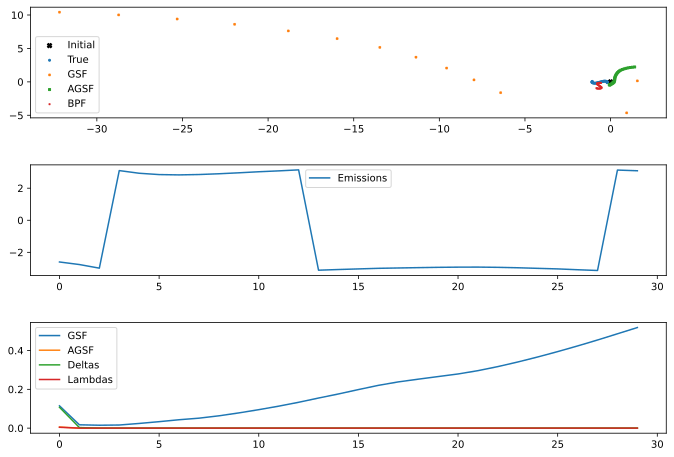

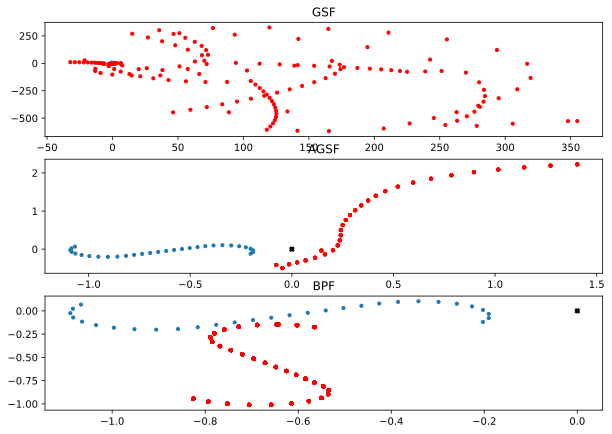

Time taken for AGSF:  6.902780055999756
Time taken for BPF:  0.5171399116516113
AGSF RMSE: 1.5334704
BPF RMSE: 2.947509


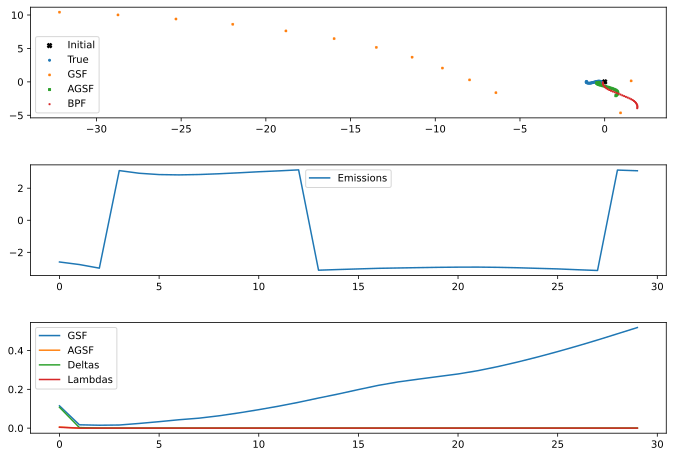

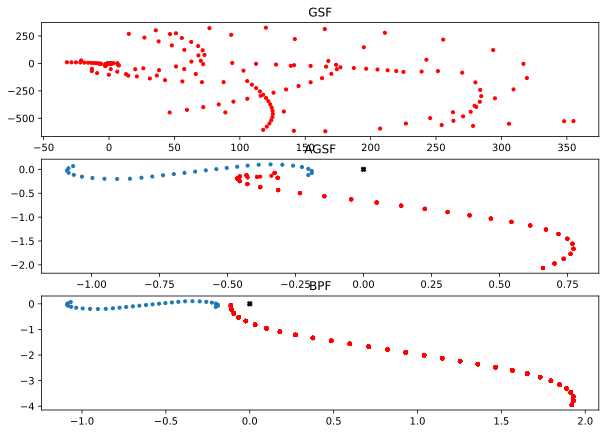

Time taken for AGSF:  7.74473762512207
Time taken for BPF:  0.5797581672668457
AGSF RMSE: 2.412425
BPF RMSE: 1.5693138


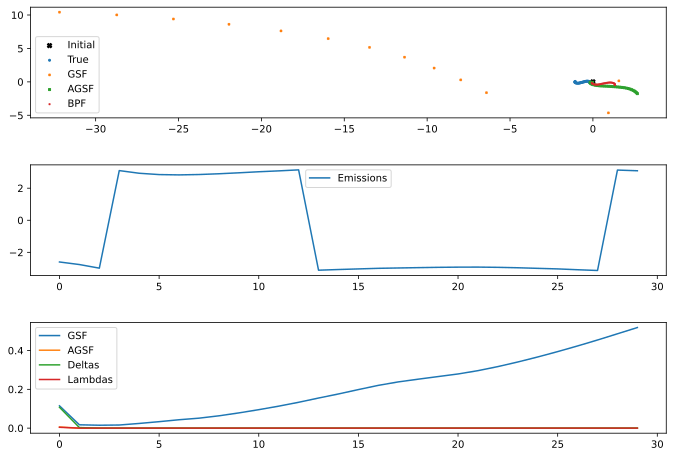

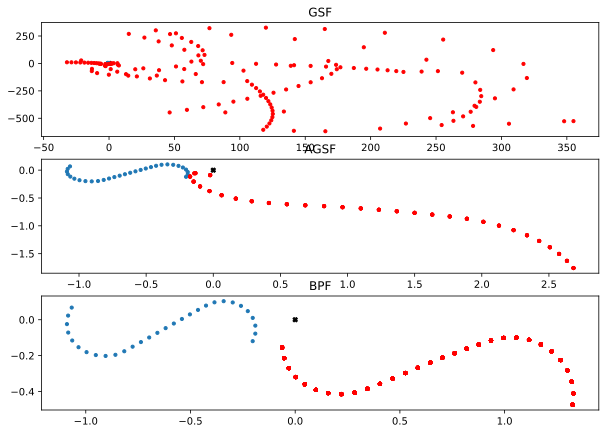

Time taken for AGSF:  8.267477989196777
Time taken for BPF:  0.5743763446807861
AGSF RMSE: 4.4213614
BPF RMSE: 2.205312


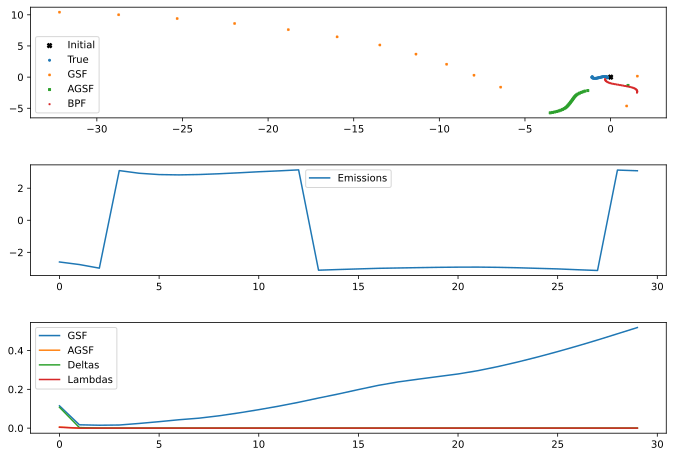

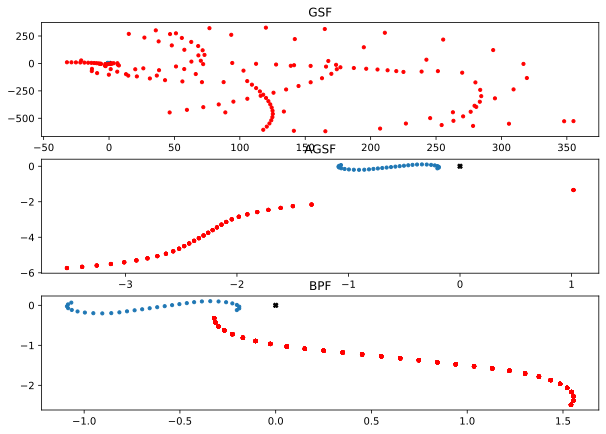

Time taken for AGSF:  7.18279504776001
Time taken for BPF:  0.5157849788665771
AGSF RMSE: 4.8374796
BPF RMSE: 2.7984467


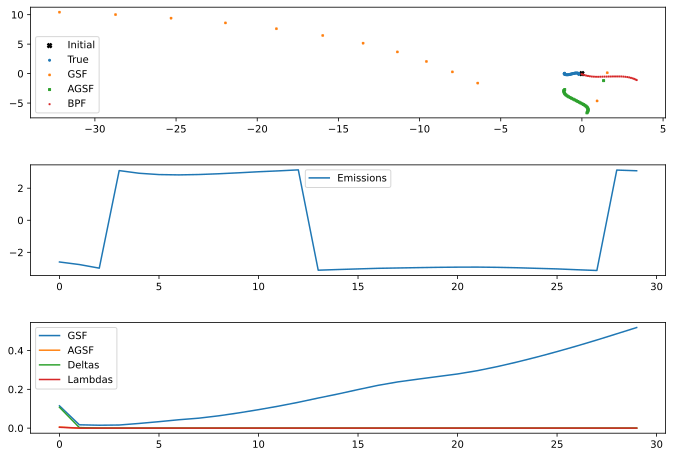

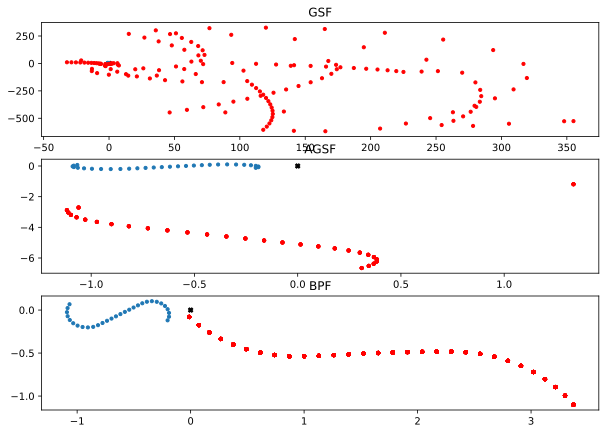

Time taken for AGSF:  8.500472068786621
Time taken for BPF:  0.5148229598999023
AGSF RMSE: 3.8986993
BPF RMSE: 1.7154988


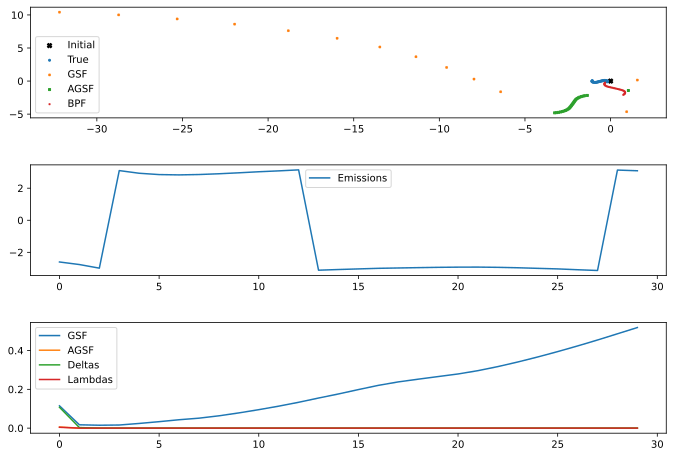

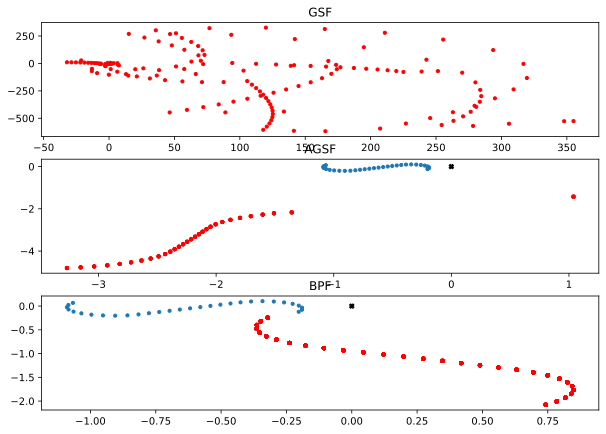

Time taken for AGSF:  6.8704540729522705
Time taken for BPF:  0.49152421951293945
AGSF RMSE: 2.5628538
BPF RMSE: 0.78285104


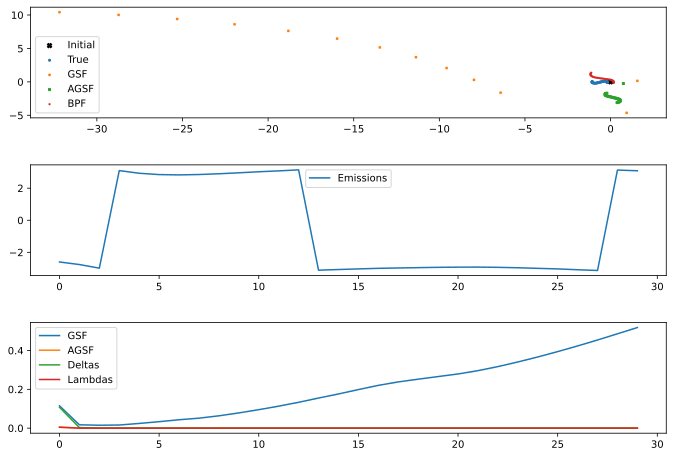

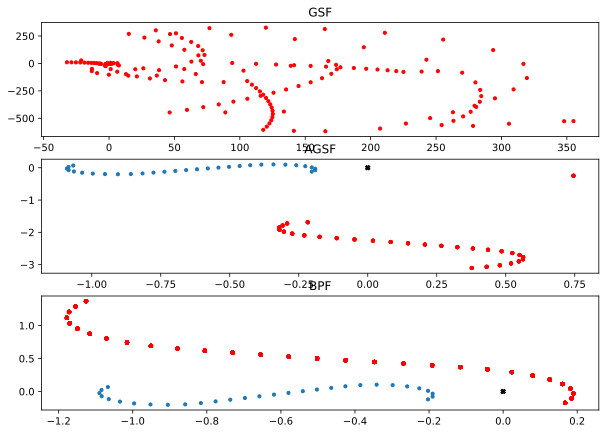

Time taken for AGSF:  7.83696174621582
Time taken for BPF:  0.5999820232391357
AGSF RMSE: 3.1574697
BPF RMSE: 1.1085312


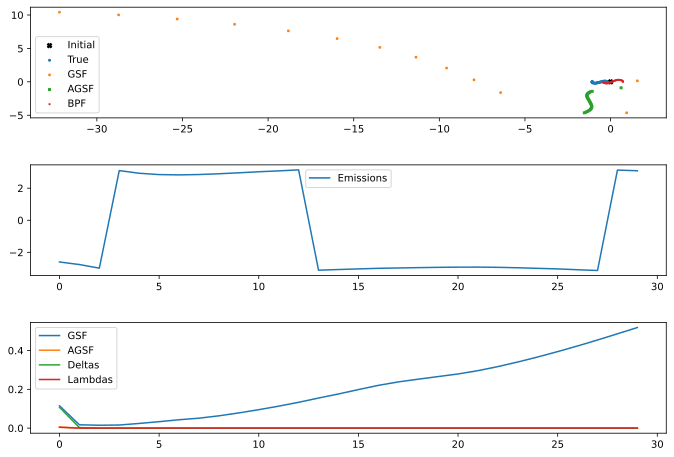

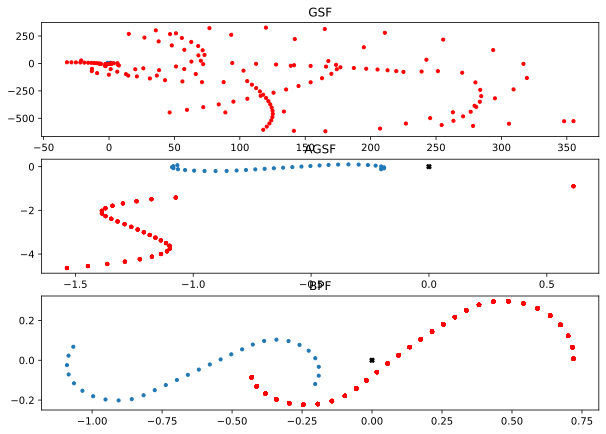

Time taken for AGSF:  7.656410217285156
Time taken for BPF:  0.4991931915283203
AGSF RMSE: 1.5801561
BPF RMSE: 1.0751735


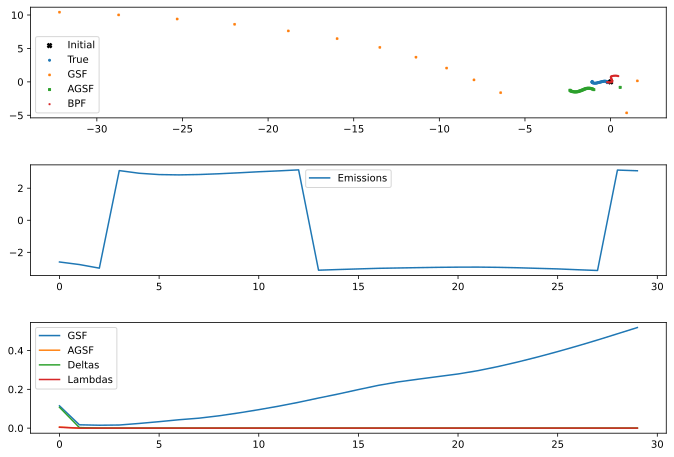

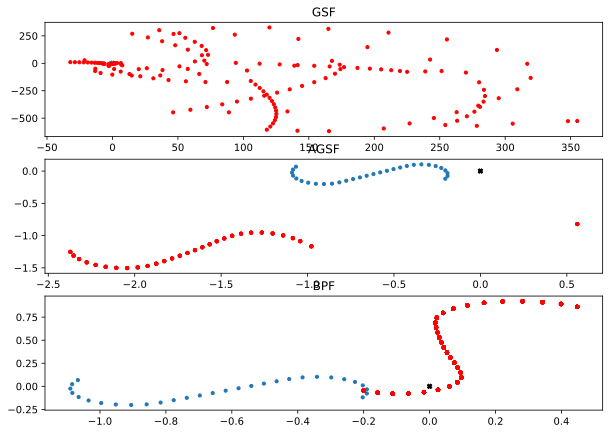

Time taken for AGSF:  7.3508710861206055
Time taken for BPF:  0.7058849334716797
AGSF RMSE: 1.7956165
BPF RMSE: 2.6365266


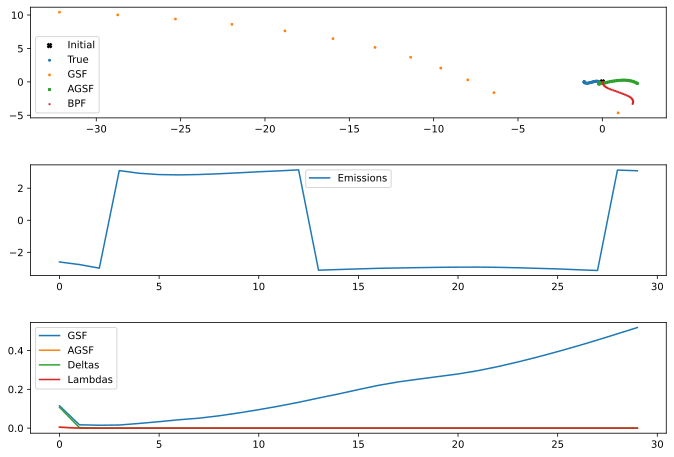

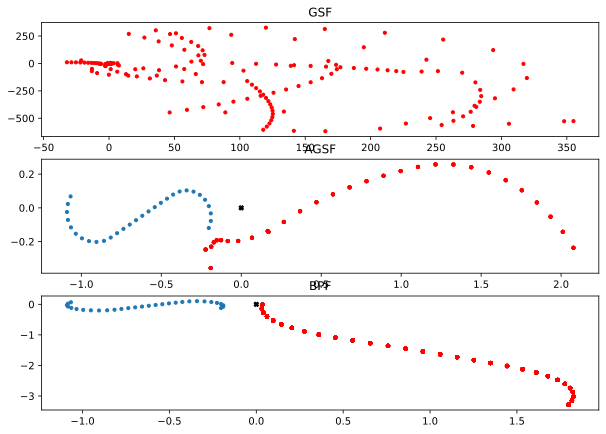

In [5]:
Nruns = 10
# GSF
M = 5
tin = time.time()
posterior_filtered_gsf = gf.gaussian_sum_filter(params, emissions, 5, 1, inputs)
point_estimate_gsf = jnp.sum(jnp.einsum('ijk,ij->ijk', posterior_filtered_gsf.means, posterior_filtered_gsf.weights), axis=0)
tout = time.time()
print('Time taken for GSF: ', tout - tin)
print('GSF RMSE:', utils.rmse(point_estimate_gsf, states)) 

next_key = jnp.array([169256403, 1825228908], dtype=jnp.uint32)
num_particles = 100
for run in range(Nruns):
    key, next_key = jr.split(next_key)
    # AGSF
    tin = time.time()
    opt_args = (.5, 0.1)
    num_components = [M, 2, 2] # has to be set correctly OW "TypeError: Cannot interpret '<function <lambda> at 0x12eae3ee0>' as a data type". Check internal containers._branch_from_node
    posterior_filtered_agsf, aux_outputs = gf.augmented_gaussian_sum_filter(params, emissions, num_components, rng_key = key, opt_args = opt_args, inputs=inputs)    
    point_estimate_agsf = jnp.sum(jnp.einsum('ijk,ij->ijk', posterior_filtered_agsf.means, posterior_filtered_agsf.weights), axis=0)
    tout = time.time()
    print('Time taken for AGSF: ', tout - tin)

    # BPF
    tin = time.time()
    ess = 0.5
    posterior_bpf = gf.bootstrap_particle_filter(params_bpf, emissions, num_particles, key, inputs, ess)
    point_estimate_bpf = jnp.sum(jnp.einsum('ijk,ij->ijk', posterior_bpf["particles"], posterior_bpf["weights"]), axis=0)
    tout = time.time()

    print('Time taken for BPF: ', tout - tin)
                                                                         
    print('AGSF RMSE:', utils.rmse(point_estimate_agsf, states))
    print('BPF RMSE:', utils.rmse(point_estimate_bpf, states))

    fig, axes = plt.subplots(3, 1, sharex=False, figsize=(10, 7))
    fig.tight_layout(pad=3.0)
    axes[0].scatter(jnp.array([0]), jnp.array([0]), label = 'Initial', s = 20, marker = 'X', color = 'black')
    axes[0].scatter(states[:,0], states[:,2], label = 'True', s = 4)
    axes[0].scatter(point_estimate_gsf[:,0], point_estimate_gsf[:,2], label = 'GSF', s = 4, marker = 'x')
    axes[0].scatter(point_estimate_agsf[:,0], point_estimate_agsf[:,2], label = 'AGSF', s = 4, marker = 's')
    # axes[0].scatter(point_estimate_agsf_opt[:,0], point_estimate_agsf_opt[:,2], label = 'AGSF-O', s = 4, marker= 'd')
    axes[0].scatter(point_estimate_bpf[:,0], point_estimate_bpf[:,2], label = 'BPF', s = 4, marker = '+')
    axes[0].legend()   

    axes[1].plot(emissions, label = 'Emissions')
    axes[1].legend()

    axes[2].plot(jnp.sum(jnp.trace(posterior_filtered_gsf.covariances, axis1=2, axis2=3), axis=0)/M, label = 'GSF')
    axes[2].plot(jnp.sum(jnp.trace(posterior_filtered_agsf.covariances, axis1=2, axis2=3), axis=0)/M, label = 'AGSF')
    axes[2].plot(jnp.sum(jnp.trace(aux_outputs['Deltas'], axis1=2, axis2=3), axis=1)/5, label = 'Deltas')
    axes[2].plot(jnp.sum(jnp.trace(aux_outputs['Lambdas'], axis1=2, axis2=3), axis=1)/25, label = 'Lambdas')
    axes[2].legend()

    ### Plot 2 (all particles)
    fig2, axes2 = plt.subplots(3, 1, sharex=False, figsize=(10, 7))
    fig.tight_layout(pad=3.0)
    axes2[0].scatter(jnp.array([0]), jnp.array([0]), label = 'Initial', s = 20, marker = 'X', color = 'black')
    axes2[0].scatter(states[:,0], states[:,2], label = 'True', s = 10)
    for m in range(M):
        axes2[0].scatter(posterior_filtered_gsf.means[m, :, 0], posterior_filtered_gsf.means[m, : ,2], label = 'GSF', s = 10, color = 'red')
    axes2[0].title.set_text('GSF')

    axes2[1].scatter(jnp.array([0]), jnp.array([0]), label = 'Initial', s = 20, marker = 'X', color = 'black')
    axes2[1].scatter(states[:,0], states[:,2], label = 'True', s = 10)
    for m in range(M):
        axes2[1].scatter(posterior_filtered_agsf.means[m, :, 0], posterior_filtered_agsf.means[m, : ,2], label = 'AGSF', s = 10,  color = 'red')
    axes2[1].title.set_text('AGSF')

    axes2[2].scatter(jnp.array([0]), jnp.array([0]), label = 'Initial', s = 20, marker = 'X', color = 'black')
    axes2[2].scatter(states[:,0], states[:,2], label = 'True', s = 10)
    for m in range(num_particles):
        axes2[2].scatter(posterior_bpf["particles"][m, :, 0], posterior_bpf["particles"][m, : ,2], label = 'BPF', s = 10, color = 'red')
    axes2[2].title.set_text('BPF')

    plt.show()

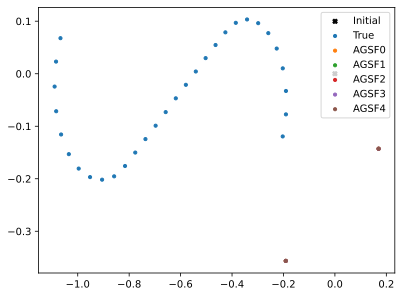

In [6]:
T=2
plt.scatter(jnp.array([0]), jnp.array([0]), label = 'Initial', s = 20, marker = 'X', color = 'black')
plt.scatter(states[:,0], states[:,2], label = 'True', s = 10)
for m in range(M):
    plt.scatter(posterior_filtered_agsf.means[m, :T, 0], posterior_filtered_agsf.means[m, :T ,2], label = 'AGSF{}'.format(m), s = 10)
plt.legend(loc='upper right', bbox_to_anchor=(1, 1))
plt.show()

In [7]:
t = 0
print('x', posterior_filtered_agsf.means[:, t, 0])
print('y', posterior_filtered_agsf.means[:, t, 2])
print('vx', posterior_filtered_agsf.means[:, t, 1])
print('vy', posterior_filtered_agsf.means[:, t, 3])

x [0.16997617 0.16997617 0.16997617 0.16997617 0.16997617]
y [-0.14284879 -0.14284879 -0.14284879 -0.14284879 -0.14284879]
vx [0.13486582 0.13486582 0.13486582 0.13486582 0.13486582]
vy [0.09619863 0.09619863 0.09619863 0.09619863 0.09619863]


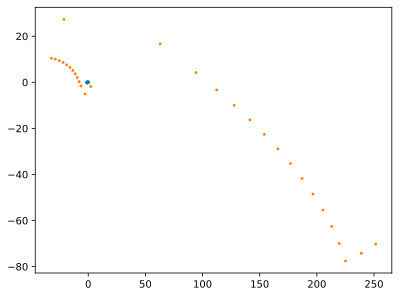

In [8]:
m=1
plt.scatter(states[:,0], states[:,2], label = 'True', s = 4)
plt.scatter(posterior_filtered_gsf.means[m,:, 0], posterior_filtered_gsf.means[m,:,2], label = 'GSF', s = 4, marker = 'x')
plt.show()

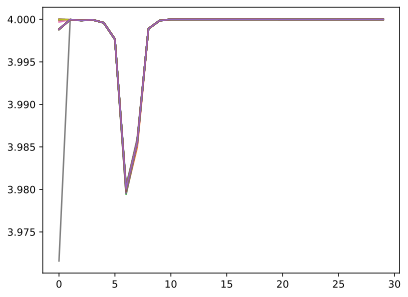

In [9]:
for m in range(25):
    plt.plot(jnp.trace(aux_outputs['grads_dyn'], axis1=2, axis2=3)[:,m], label = 'grad_dyn{m}'.format(m=m))
plt.show()

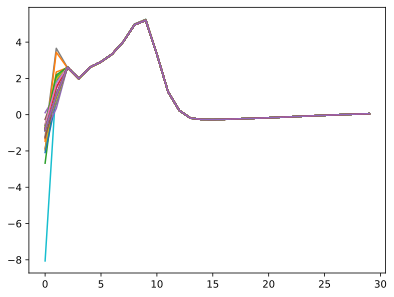

In [10]:
for m in range(125):
    plt.plot(jnp.trace(aux_outputs['grads_obs'], axis1=2, axis2=3)[:,m], label = 'grad_dyn{m}'.format(m=m))
# plt.legend()
plt.show()

In [11]:
jnp.trace(aux_outputs['gain'], axis1=2, axis2=3).shape

(30, 20)

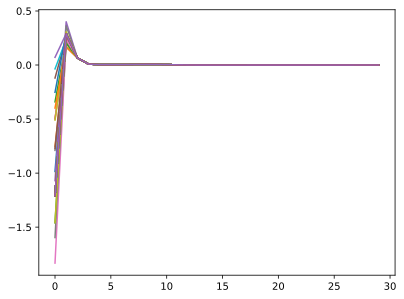

In [12]:
for m in range(125):
    plt.plot(jnp.trace(aux_outputs['gain'], axis1=2, axis2=3)[:,m] , label = 'grad_dyn{m}'.format(m=m))
# plt.legend()
plt.show()

In [13]:
posterior_bpf['weights'][:,5]

Array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01], dtype=float32)

In [14]:
print('GSF RMSE:', utils.rmse(point_estimate_gsf, states))                                                                           
print('AGSF RMSE:', utils.rmse(point_estimate_agsf, states))
print('BPF RMSE:', utils.rmse(point_estimate_bpf, states))

GSF RMSE: nan
AGSF RMSE: 1.7956165
BPF RMSE: 2.6365266


## Plots

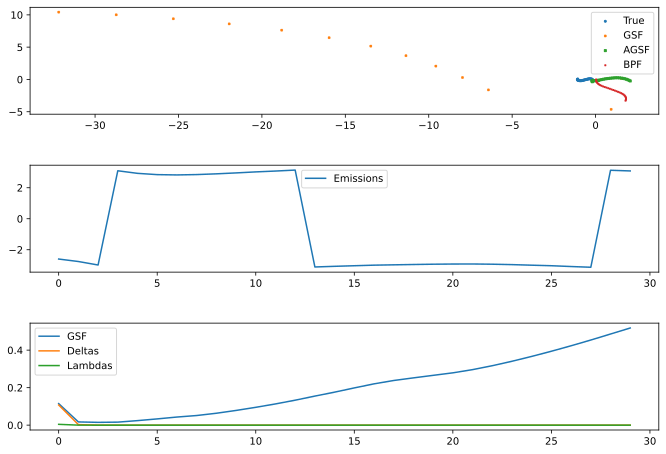

In [15]:
fig, axes = plt.subplots(3, 1, sharex=False, figsize=(10, 7))
fig.tight_layout(pad=3.0)
axes[0].scatter(states[:,0], states[:,2], label = 'True', s = 4)
axes[0].scatter(point_estimate_gsf[:,0], point_estimate_gsf[:,2], label = 'GSF', s = 4, marker = 'x')
axes[0].scatter(point_estimate_agsf[:,0], point_estimate_agsf[:,2], label = 'AGSF', s = 4, marker = 's')
# axes[0].scatter(point_estimate_agsf_opt[:,0], point_estimate_agsf_opt[:,2], label = 'AGSF-O', s = 4, marker= 'd')
axes[0].scatter(point_estimate_bpf[:,0], point_estimate_bpf[:,2], label = 'BPF', s = 4, marker = '+')
axes[0].legend()   

axes[1].plot(emissions, label = 'Emissions')
axes[1].legend()

axes[2].plot(jnp.sum(jnp.trace(posterior_filtered_gsf.covariances, axis1=2, axis2=3), axis=0)/M, label = 'GSF')
axes[2].plot(jnp.sum(jnp.trace(aux_outputs['Deltas'], axis1=2, axis2=3), axis=1)/5, label = 'Deltas')
axes[2].plot(jnp.sum(jnp.trace(aux_outputs['Lambdas'], axis1=2, axis2=3), axis=1)/25, label = 'Lambdas')
axes[2].legend()

plt.show()

In [16]:
jnp.allclose(posterior_bpf["particles"][0, :], posterior_bpf["particles"][1, :], atol=1e-1)
print(posterior_bpf["particles"][:, 16])
posterior_bpf["weights"][16]

[[ 1.1555101   0.19520512 -1.7302699  -0.18733735]
 [ 1.1556844   0.1957858  -1.7305524  -0.1881251 ]
 [ 1.1556844   0.1957858  -1.7305524  -0.1881251 ]
 [ 1.1555101   0.19520512 -1.7302699  -0.18733735]
 [ 1.1556844   0.1957858  -1.7305524  -0.1881251 ]
 [ 1.1556844   0.1957858  -1.7305524  -0.1881251 ]
 [ 1.1556844   0.1957858  -1.7305524  -0.1881251 ]
 [ 1.1555101   0.19520512 -1.7302699  -0.18733735]
 [ 1.1555101   0.19520512 -1.7302699  -0.18733735]
 [ 1.1556844   0.1957858  -1.7305524  -0.1881251 ]
 [ 1.1555101   0.19520512 -1.7302699  -0.18733735]
 [ 1.1556844   0.1957858  -1.7305524  -0.1881251 ]
 [ 1.1555101   0.19520512 -1.7302699  -0.18733735]
 [ 1.1556844   0.1957858  -1.7305524  -0.1881251 ]
 [ 1.1556844   0.1957858  -1.7305524  -0.1881251 ]
 [ 1.1556844   0.1957858  -1.7305524  -0.1881251 ]
 [ 1.1556844   0.1957858  -1.7305524  -0.1881251 ]
 [ 1.1555101   0.19520512 -1.7302699  -0.18733735]
 [ 1.1556844   0.1957858  -1.7305524  -0.1881251 ]
 [ 1.1556844   0.1957858  -1.73

Array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], dtype=float32)

### GSF

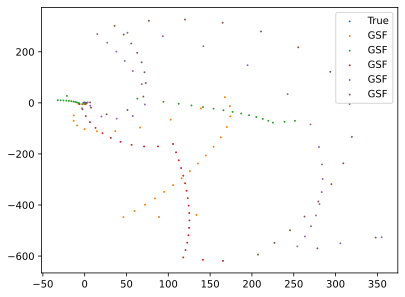

In [17]:
# num_components = M

# fig, axes = plt.subplots(4, 1, sharex=True, figsize=(10, 7))
# fig.tight_layout(pad=3.0)
# axes[0].plot(states, label="xs")
# leg = ["states"]
# for m in range(M):
#     axes[0].plot(posterior_filtered_gsf.means[m])
#     leg.append("model {}".format(m))
#     axes[0].set_title("filtered means")
# #axes[0].legend(leg)

# if state_dim ==1:
#     for m in range(M):
#         axes[1].plot(posterior_filtered_gsf.covariances[m])
#         axes[1].set_title("filtered covariances")

# for m in range(M):
#     axes[2].plot(posterior_filtered_gsf.weights[m])
#     axes[2].set_title("weights")

# axes[3].plot(states, label="xs")
# leg = ["states", "GSF"]
# axes[3].plot(point_estimate_gsf)
# axes[3].legend(leg)
# axes[3].set_title("point estimate")
# plt.show()

plt.scatter(states[:, 0], states[:,2 ], label = 'True', s = 1)
for m in range(M):
    plt.scatter(posterior_filtered_gsf.means[m, :, 0], posterior_filtered_gsf.means[m, : ,2], label = 'GSF', s = 1)
    plt.legend()   
plt.show()

### AGSF

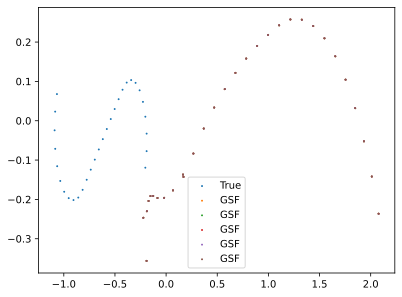

In [18]:
# fig, axes = plt.subplots(4, 1, sharex=True, figsize=(10, 7))
# fig.tight_layout(pad=3.0)
# axes[0].plot(states, label="xs")
# leg = ["states"]
# for m in range(M):
#     axes[0].plot(posterior_filtered_agsf.means[m])
#     leg.append("model {}".format(m))
#     axes[0].set_title("filtered means")

# #axes[0].legend(leg)

# if state_dim == 1:
#     for m in range(M):
#         axes[1].plot(posterior_filtered_agsf.covariances[m].squeeze())
#         axes[1].set_title("filtered covariances")

# else:
#     for m in range(jnp.prod(num_components)):
#         axes[1].plot(aux_outputs["updated_means"][:,m])
#         axes[1].set_title("updated means")

# for m in range(jnp.prod(jnp.array(num_components))):
#         axes[2].plot(aux_outputs["pre_weights"][:,m])
#         axes[2].set_title("updated pre_weights")

# axes[3].plot(states, label="xs")
# leg = ["states", "AGSF"]
# axes[3].plot(point_estimate_agsf)
# axes[3].legend(leg)
# axes[3].set_title("point estimate")

# plt.show()

## Scatter plots (for target tracking example)
plt.scatter(states[:, 0], states[:,2 ], label = 'True', s = 1)
for m in range(M):
    plt.scatter(posterior_filtered_agsf.means[m, :, 0], posterior_filtered_agsf.means[m, : ,2], label = 'GSF', s = 1)
    plt.legend()   
plt.show()

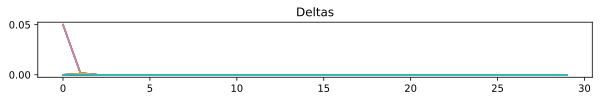

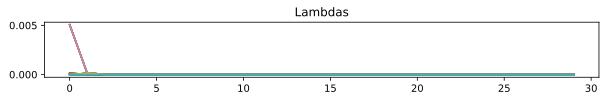

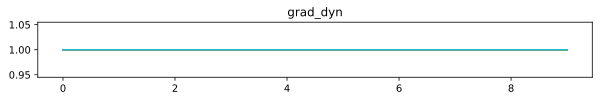

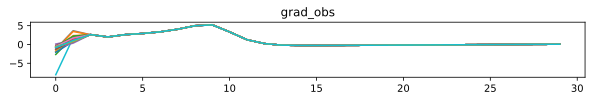

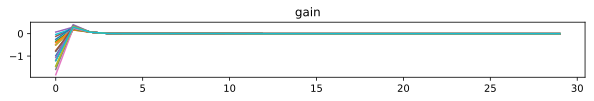

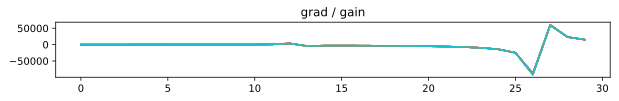

In [19]:
# plot Deltas
plt.figure(figsize=(10, 1))
for i in range(aux_outputs["Deltas"].shape[1]):
    plt.plot(aux_outputs["Deltas"][:, i, 0])
plt.title('Deltas')
plt.show()

# plot Lambdas
plt.figure(figsize=(10, 1))
for i in range(aux_outputs["Lambdas"].shape[1]):
    plt.plot(aux_outputs["Lambdas"][:, i, 0])
plt.title('Lambdas')
plt.show()

# plot grads_dyn
plt.figure(figsize=(10, 1))
for i in range(aux_outputs["grads_dyn"].shape[0]):
    plt.plot(aux_outputs["grads_dyn"][i, :, 0, 0])
plt.title('grad_dyn')
plt.show()

# plot grads_obs
plt.figure(figsize=(10, 1))
for i in range(aux_outputs["grads_obs"].shape[1]):
    plt.plot(aux_outputs["grads_obs"][:, i, 0, 0])
plt.title('grad_obs')
plt.show()

# plot gain
plt.figure(figsize=(10, 1))
for i in range(aux_outputs["gain"].shape[1]):
    plt.plot(aux_outputs["gain"][:, i, 0, 0])
plt.title('gain')
plt.show()

# plot grads_dyn / gain
plt.figure(figsize=(10, 1))
for i in range(aux_outputs["grads_dyn"].shape[1]):
    plt.plot(aux_outputs["grads_dyn"][:, i, 0, 0] / aux_outputs["gain"][:, i * 3, 0, 0])
plt.title('grad / gain')
plt.show()

### BPF

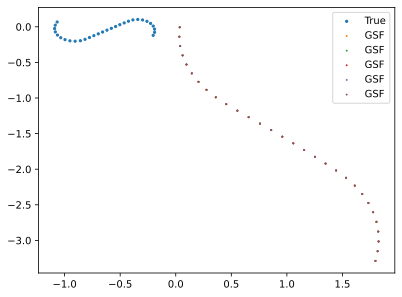

In [20]:
# fig, axes = plt.subplots(2, 1, sharex=True, figsize=(10, 7))
# fig.tight_layout(pad=3.0)
# axes[0].plot(states, label="xs")
# leg = ["states"]
# for m in range(num_particles):
#     axes[0].plot(posterior_bpf["particles"][m])
#     leg.append("model {}".format(m))
#     axes[0].set_title("particles")

# for m in range(num_particles):
#     axes[1].plot(posterior_bpf["weights"][m])
#     axes[1].set_title("weights")

# plt.show()

## Scatter plots (for target tracking example)
plt.scatter(states[:, 0], states[:,2 ], label = 'True', s = 5)
for m in range(M):
    plt.scatter(posterior_bpf['particles'][m, :, 0], posterior_bpf['particles'][m, : ,2], label = 'GSF', s = 1)
    plt.legend()   
plt.show()